# Supervised Learning Burn Severity

In [1]:
%load_ext autoreload

In [2]:
#load in modules
%autoreload 2
from wildfireassessment.ops import * #my package
from wildfireassessment.plots import * #my package
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy.ma as ma
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
#from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
%matplotlib inline

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Load segments
Read vector files into geodataframes. Then will convert to Numpy matrix X and y

In [3]:
#read in datapaths of labelled data
filepaths = [Path("./data/shapefiles/segments_2011023_0.shp"), Path("./data/shapefiles/segments_2011201_0.shp"),
             Path("./data/shapefiles/segments_2011203_0.shp"), Path("./data/shapefiles/segments_2010133_0.shp"),
             Path("./data/shapefiles/segments_2011200_0.shp")]

In [4]:
gdfs = []
for filepath in filepaths:
    gdfs.append(gpd.read_file(filepath))
gdfs[0].head()

,seg_index,area_m,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,...,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,land_class,burn_class,geometry
0,17,3265.85,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,...,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,forest,0,"POLYGON ((-121.5388488769531 39.7265625, -121...."
1,37,2659.18,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,...,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,forest,0,"POLYGON ((-121.5206954058479 39.7265625, -121...."
2,3,2894.16,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,...,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,forest,1,"POLYGON ((-121.5505308263442 39.7265625, -121...."
3,27,5323.94,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,...,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,forest,0,"POLYGON ((-121.5298865823185 39.7265625, -121...."
4,47,2805.50,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,...,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,forest,0,POLYGON ((-121.5225444120519 39.72651762120864...


In [5]:
#'Blue_value' - 'dSI_bn' will be X, y is 'burn_class' 
gdfs[0].keys()

Index(['seg_index', 'area_m', 'blue_value', 'blue_val_1', 'green_valu',
       'green_va_1', 'nir_value', 'nir_value_', 'red_value', 'red_value_',
       'SI_bg_post', 'SI_br_post', 'SI_bn_post', 'SI_gb_post', 'SI_gr_post',
       'SI_gn_post', 'SI_rb_post', 'SI_rg_post', 'SI_rn_post', 'SI_nb_post',
       'SI_ng_post', 'SI_nr_post', 'SI_bg_pre', 'SI_br_pre', 'SI_bn_pre',
       'SI_gb_pre', 'SI_gr_pre', 'SI_gn_pre', 'SI_rb_pre', 'SI_rg_pre',
       'SI_rn_pre', 'SI_nb_pre', 'SI_ng_pre', 'SI_nr_pre', 'dSI_nb', 'dSI_rg',
       'dSI_bg', 'dSI_gr', 'dSI_gn', 'dSI_rb', 'dSI_br', 'dSI_gb', 'dSI_nr',
       'dSI_rn', 'dSI_ng', 'dSI_bn', 'land_class', 'burn_class', 'geometry'],
      dtype='object')

In [6]:
gdf_all = pd.concat(gdfs)
gdf_all.dropna(inplace=True)
gdf_all = gdf_all.astype({'burn_class' : 'uint8'})
gdf_all

,seg_index,area_m,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,...,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,land_class,burn_class,geometry
0,17,3265.85,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,...,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,forest,0,"POLYGON ((-121.5388488769531 39.7265625, -121...."
1,37,2659.18,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,...,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,forest,0,"POLYGON ((-121.5206954058479 39.7265625, -121...."
2,3,2894.16,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,...,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,forest,1,"POLYGON ((-121.5505308263442 39.7265625, -121...."
3,27,5323.94,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,...,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,forest,0,"POLYGON ((-121.5298865823185 39.7265625, -121...."
4,47,2805.50,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,...,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,forest,0,POLYGON ((-121.5225444120519 39.72651762120864...
5,25,3930.80,79.232492,84.662461,54.582256,55.686909,23.791667,87.875000,71.843533,65.856309,...,0.076033,-0.076033,0.022241,-0.645678,0.645678,-0.617078,0.556754,forest,0,"POLYGON ((-121.5309816248277 39.7265625, -121...."
6,51,2720.56,68.351869,56.855857,48.352097,39.038628,20.333333,81.400000,55.520624,40.307315,...,0.066733,-0.066733,0.014429,-0.801517,0.801517,-0.759655,0.718976,forest,0,POLYGON ((-121.5260314941406 39.72646825453814...
7,2,4345.89,84.417933,76.088665,64.176546,53.905771,29.851852,83.370370,72.657536,61.513161,...,0.031054,-0.031054,0.034426,-0.568439,0.568439,-0.579683,0.523185,forest,1,"POLYGON ((-121.5510873233571 39.7265625, -121...."
8,4,4158.65,74.688110,79.030712,55.724711,58.391204,14.846154,68.653846,65.502199,70.291837,...,-0.007001,0.007001,0.004780,-0.618667,0.618667,-0.660035,0.598106,forest,1,"POLYGON ((-121.5499653535731 39.7265625, -121...."
9,13,3688.38,89.508993,58.461002,63.013952,38.132795,34.782609,101.782609,76.674063,36.478904,...,0.154303,-0.154303,0.036739,-0.848174,0.848174,-0.743591,0.710655,forest,1,"POLYGON ((-121.5420936135685 39.7265625, -121...."


In [7]:
df = gdf_all.drop(columns=['seg_index', 'area_m', 'land_class', 'geometry'])
df.head()

,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,SI_bg_post,SI_br_post,...,dSI_gr,dSI_gn,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,burn_class
0,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,0.195175,0.091698,...,-0.047628,0.389213,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,0
1,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,0.195936,0.088270,...,-0.069467,0.548766,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,0
2,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,0.138966,0.063881,...,0.045037,0.536115,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,1
3,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,0.165004,0.040925,...,-0.031099,0.593989,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,0
4,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,0.224980,0.160622,...,-0.027575,0.306810,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,0


In [8]:
df_rm = df.drop(columns=['SI_bg_post', 'SI_br_post', 'SI_bn_post', 'SI_bg_pre', 'SI_br_pre', 'SI_bn_pre',
                     'SI_gr_post', 'SI_gn_post', 'SI_gr_pre', 'SI_gn_pre', 'SI_rn_post', 'SI_rn_pre', 
                     'dSI_bg', 'dSI_gr', 'dSI_gn', 'dSI_br', 'dSI_rn', 'dSI_bn'])
df_rm.head()

,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,SI_gb_post,SI_rb_post,...,SI_nb_pre,SI_ng_pre,SI_nr_pre,dSI_nb,dSI_rg,dSI_rb,dSI_gb,dSI_nr,dSI_ng,burn_class
0,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,-0.195175,-0.091698,...,0.152732,0.328302,0.275794,-0.405810,0.047628,0.036776,-0.010337,-0.441008,-0.389213,0
1,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,-0.195936,-0.088270,...,0.201713,0.386683,0.352048,-0.548713,0.069467,0.073555,0.004681,-0.618952,-0.548766,0
2,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,-0.138966,-0.063881,...,-0.122847,0.016083,-0.104915,-0.491737,-0.045037,-0.045714,-0.000309,-0.468292,-0.536115,1
3,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,-0.165004,-0.040925,...,-0.037165,0.154423,0.061491,-0.526519,0.031099,0.057506,0.025492,-0.596595,-0.593989,0
4,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,-0.224980,-0.160622,...,0.192553,0.375329,0.341152,-0.351463,0.027575,-0.001575,-0.027965,-0.339396,-0.306810,0


In [9]:
#build X and y
X = df_rm.drop(columns=['burn_class']).to_numpy()
y = df_rm['burn_class'].to_numpy()

### X y shuffled train-test split 67/33

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

In [11]:
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)

print("\n# of burn labels in train: ", np.count_nonzero(y_train))
print("# of non-burn labels in train: ", y_train.shape[0]-np.count_nonzero(y_train))
print("# of burn labels in test: ", np.count_nonzero(y_test))
print("# of non-burn labels in test: ", y_test.shape[0]-np.count_nonzero(y_test))

train shape:  (9437, 26)
test shape:  (4649, 26)

# of burn labels in train:  6056
# of non-burn labels in train:  3381
# of burn labels in test:  2983
# of non-burn labels in test:  1666


In [12]:
class_names = np.where(np.unique(y) == 1, "burnt", "non-burnt")
class_names

array(['non-burnt', 'burnt'], dtype='<U9')

# Binary Classification Burnt/Non-Burnt

## Random Forest Classifier

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
rf.score(X_test, y_test)

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8565282856528286

Confusion matrix, without normalization
[[1313  353]
 [ 314 2669]]
Normalized confusion matrix
[[0.78811525 0.21188475]
 [0.10526316 0.89473684]]


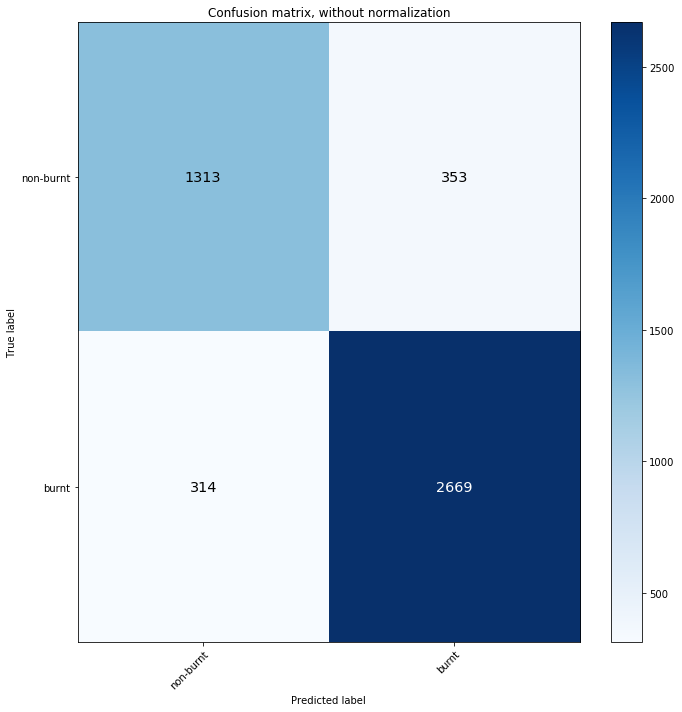

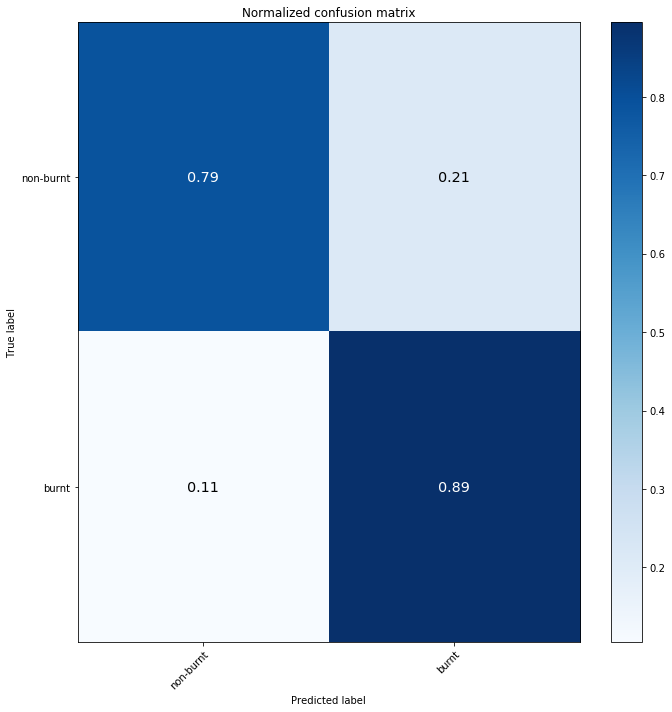

In [14]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

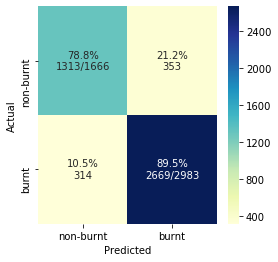

In [15]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_rf_cm.png")

In [16]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1313, 353, 314, 2669)
	Accuracy = 85.65%
	Misclassification Rate = 14.35%
	Precision = 88.32%
	Recall = 89.47%
	F1-Score = 88.89%


#### Cross_val_score

In [17]:
scores_rf = cross_val_score(rf, X_train, y_train, cv=10)
scores_rf_p = cross_val_score(rf, X_train, y_train, scoring='precision', cv=10)
scores_rf_r = cross_val_score(rf, X_train, y_train, scoring='recall', cv=10)
scores_rf_f = cross_val_score(rf, X_train, y_train, scoring='f1', cv=10)
scores_rf

array([0.84656085, 0.85805085, 0.84427966, 0.86016949, 0.87288136,
       0.85381356, 0.86002121, 0.84729586, 0.86956522, 0.85790032])

In [18]:
def strScoreConf(mean, std, conf=1.96):
    return "%0.4f (+/- %0.4f)" % (mean, std * conf)

def strScoreCI(mean, std, conf=1.96, n=10):
    SE = std/math.sqrt(n)
    return "%0.4f (+/- %0.4f)" % (mean, SE * conf)#"95%% CI: [%0.4f, %0.4f]" % (mean - conf*SE, mean + conf*SE)

models_df_rf = pd.DataFrame({  
  'Model': ['RandForest'],
  'Accuracy' : [strScoreConf(scores_rf.mean(), scores_rf.std())],
  'Precision': [strScoreConf(scores_rf_p.mean(), scores_rf_p.std())],
  'Recall' : [strScoreConf(scores_rf_r.mean(), scores_rf_r.std())],
  'F1' : [strScoreConf(scores_rf_f.mean(), scores_rf_f.std())]
})

models_df_rf_CI = pd.DataFrame({  
  'Model': ['RandForest'],
  'Accuracy' : [strScoreCI(scores_rf.mean(), scores_rf.std())],
  'Precision': [strScoreCI(scores_rf_p.mean(), scores_rf_p.std())],
  'Recall' : [strScoreCI(scores_rf_r.mean(), scores_rf_r.std())],
  'F1' : [strScoreCI(scores_rf_f.mean(), scores_rf_f.std())]
})
models_df_rf

,Model,Accuracy,Precision,Recall,F1
0,RandForest,0.8571 (+/- 0.0176),0.8862 (+/- 0.0197),0.8937 (+/- 0.0212),0.8921 (+/- 0.0113)


In [19]:
models_df_rf_CI

,Model,Accuracy,Precision,Recall,F1
0,RandForest,0.8571 (+/- 0.0056),0.8862 (+/- 0.0062),0.8937 (+/- 0.0067),0.8921 (+/- 0.0036)


In [20]:
print("95%% CI: [%0.4f, %0.4f]" % (scores_rf.mean() - 1.96*scores_rf.std()/math.sqrt(10), scores_rf.mean() + 1.96*scores_rf.std()/math.sqrt(10)))

95% CI: [0.8515, 0.8626]


## Logistic Regression

In [21]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
lr.score(X_test, y_test)

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8320068832006883

Confusion matrix, without normalization
[[1105  561]
 [ 220 2763]]
Normalized confusion matrix
[[0.66326531 0.33673469]
 [0.07375126 0.92624874]]


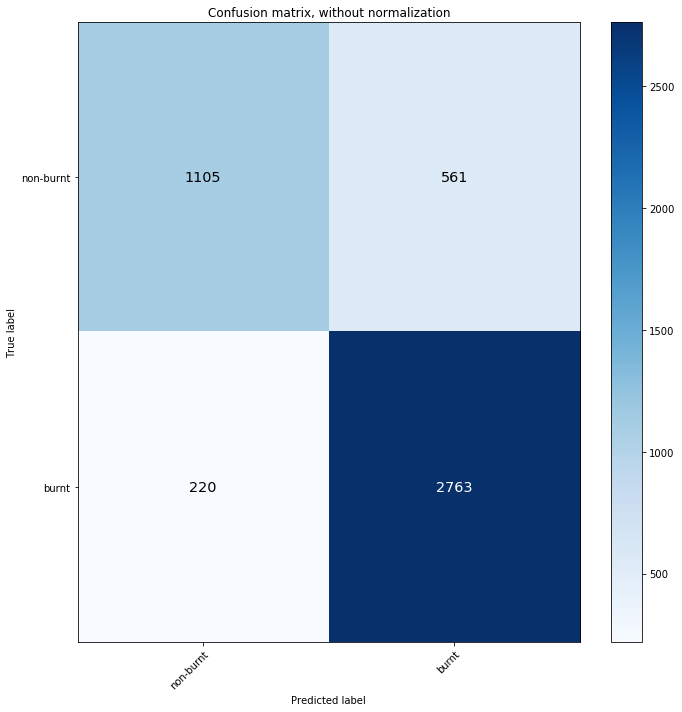

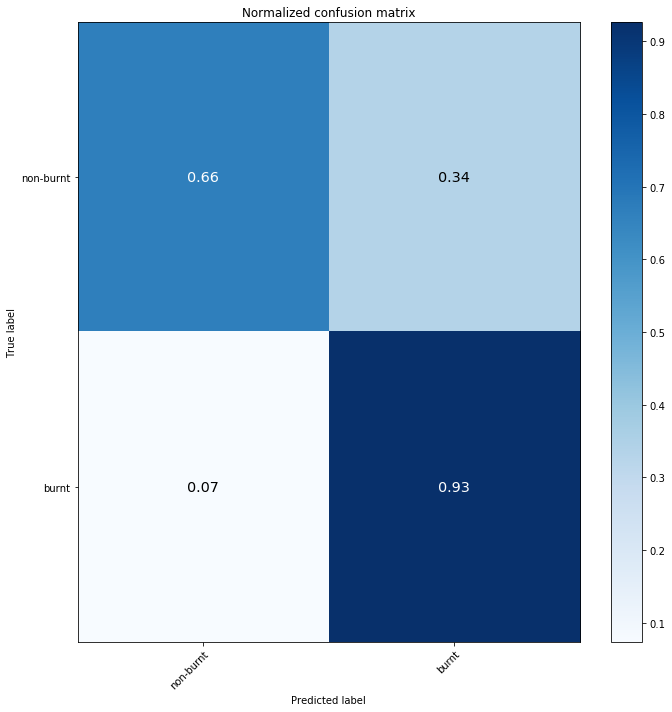

In [22]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

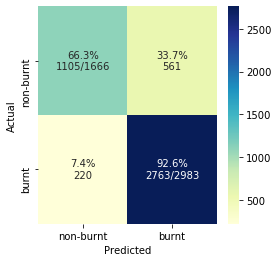

In [23]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_lr_cm.png")

In [24]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1105, 561, 220, 2763)
	Accuracy = 83.20%
	Misclassification Rate = 16.80%
	Precision = 83.12%
	Recall = 92.62%
	F1-Score = 87.62%


#### Cross Validation

In [25]:
scores_lr = cross_val_score(lr, X_train, y_train, cv=10)
scores_lr_p = cross_val_score(lr, X_train, y_train, scoring='precision', cv=10)
scores_lr_r = cross_val_score(lr, X_train, y_train, scoring='recall', cv=10)
scores_lr_f = cross_val_score(lr, X_train, y_train, scoring='f1', cv=10)
scores_lr

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.83068783, 0.82415254, 0.81355932, 0.82521186, 0.85063559,
       0.82838983, 0.84941676, 0.81866384, 0.83244963, 0.83987275])

In [26]:
models_df_lr = pd.DataFrame({
  'Model': ['LogReg'],
  'Accuracy' : [strScoreConf(scores_lr.mean(), scores_lr.std())],
  'Precision': [strScoreConf(scores_lr_p.mean(), scores_lr_p.std())],
  'Recall' : [strScoreConf(scores_lr_r.mean(), scores_lr_r.std())],
  'F1' : [strScoreConf(scores_lr_f.mean(), scores_lr_f.std())]
})
models_df_lr

,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.8313 (+/- 0.0228),0.8360 (+/- 0.0239),0.9173 (+/- 0.0241),0.8747 (+/- 0.0164)


## Naive Bayes

### Gaussian NB

In [27]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predict = gnb.predict(X_test)
gnb.score(X_test, y_test)

0.804258980425898

Confusion matrix, without normalization
[[1095  571]
 [ 339 2644]]
Normalized confusion matrix
[[0.65726291 0.34273709]
 [0.11364398 0.88635602]]


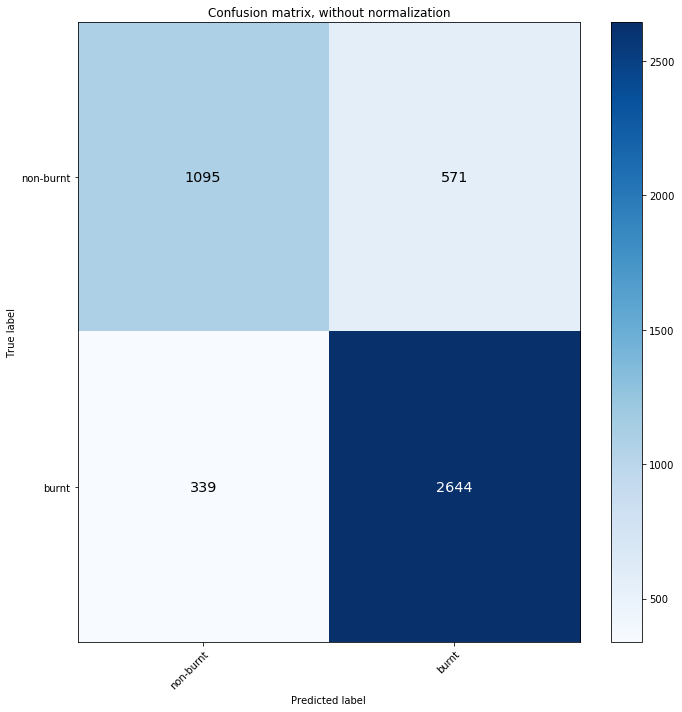

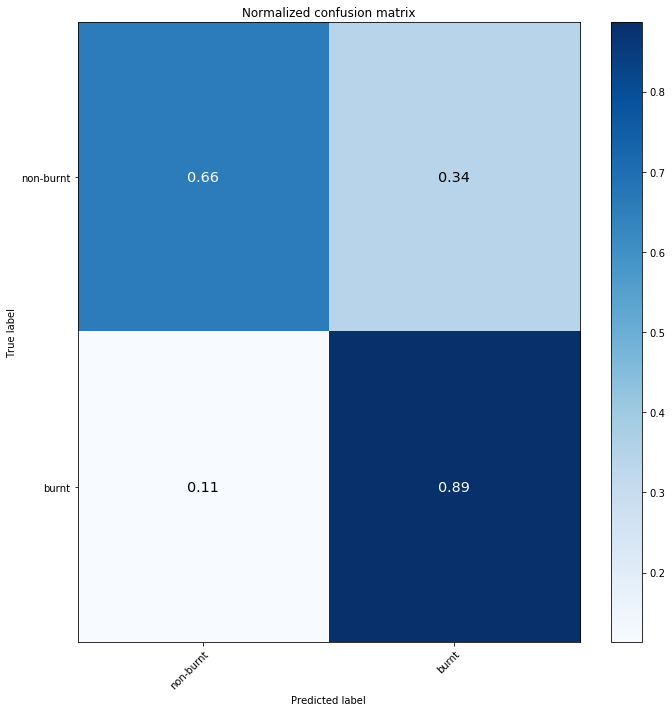

In [28]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

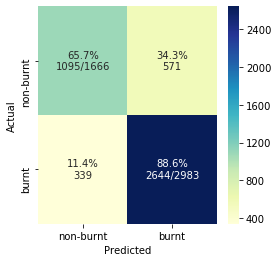

In [29]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_gnb_cm.png")

In [30]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1095, 571, 339, 2644)
	Accuracy = 80.43%
	Misclassification Rate = 19.57%
	Precision = 82.24%
	Recall = 88.64%
	F1-Score = 85.32%


#### Cross-validation

In [31]:
scores_gnb = cross_val_score(gnb, X_train, y_train, cv=10)
scores_gnb_p = cross_val_score(gnb, X_train, y_train, scoring='precision', cv=10)
scores_gnb_r = cross_val_score(gnb, X_train, y_train, scoring='recall', cv=10)
scores_gnb_f = cross_val_score(gnb, X_train, y_train, scoring='f1', cv=10)
scores_gnb

array([0.81904762, 0.8220339 , 0.80508475, 0.80720339, 0.8125    ,
       0.8125    , 0.83138918, 0.80593849, 0.81866384, 0.79427359])

In [32]:
models_df_gnb = pd.DataFrame({  
  'Model': ['GaussNB'],
  'Accuracy' : [strScoreConf(scores_gnb.mean(), scores_gnb.std())],
  'Precision': [strScoreConf(scores_gnb_p.mean(), scores_gnb_p.std())],
  'Recall' : [strScoreConf(scores_gnb_r.mean(), scores_gnb_r.std())],
  'F1' : [strScoreConf(scores_gnb_f.mean(), scores_gnb_f.std())]
})
models_df_gnb

,Model,Accuracy,Precision,Recall,F1
0,GaussNB,0.8129 (+/- 0.0195),0.8364 (+/- 0.0225),0.8809 (+/- 0.0204),0.8580 (+/- 0.0141)


### Bernoulli NB

In [33]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_predict = bnb.predict(X_test)
bnb.score(X_test, y_test)

0.7526349752634975

Confusion matrix, without normalization
[[ 725  941]
 [ 209 2774]]
Normalized confusion matrix
[[0.43517407 0.56482593]
 [0.07006369 0.92993631]]


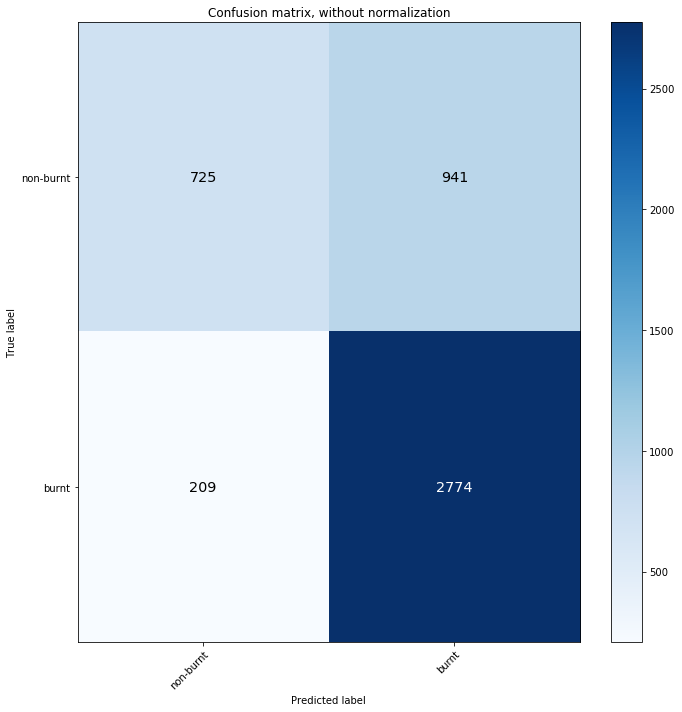

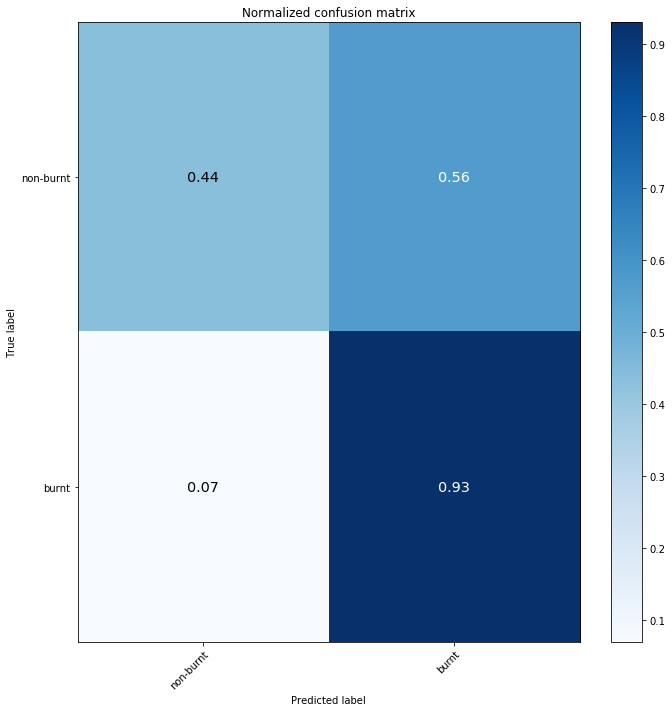

In [34]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

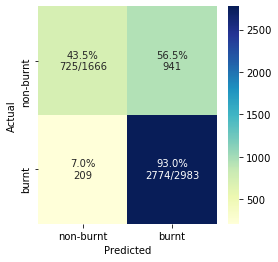

In [35]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_bnb_cm.png")

In [36]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (725, 941, 209, 2774)
	Accuracy = 75.26%
	Misclassification Rate = 24.74%
	Precision = 74.67%
	Recall = 92.99%
	F1-Score = 82.83%


#### Cross-validation

In [37]:
scores_bnb = cross_val_score(bnb, X_train, y_train, cv=10)
scores_bnb_p = cross_val_score(bnb, X_train, y_train, scoring='precision', cv=10)
scores_bnb_r = cross_val_score(bnb, X_train, y_train, scoring='recall', cv=10)
scores_bnb_f = cross_val_score(bnb, X_train, y_train, scoring='f1', cv=10)
scores_bnb

array([0.76613757, 0.76694915, 0.74364407, 0.74470339, 0.77118644,
       0.7690678 , 0.7592789 , 0.76776246, 0.75185578, 0.76670201])

In [38]:
models_df_bnb = pd.DataFrame({  
  'Model': ['BernNB'],
  'Accuracy' : [strScoreConf(scores_bnb.mean(), scores_bnb.std())],
  'Precision': [strScoreConf(scores_bnb_p.mean(), scores_bnb_p.std())],
  'Recall' : [strScoreConf(scores_bnb_r.mean(), scores_bnb_r.std())],
  'F1' : [strScoreConf(scores_bnb_f.mean(), scores_bnb_f.std())]
})
models_df_bnb

,Model,Accuracy,Precision,Recall,F1
0,BernNB,0.7607 (+/- 0.0192),0.7528 (+/- 0.0184),0.9341 (+/- 0.0141),0.8337 (+/- 0.0115)


## Stochastic Gradient Descent (SGD)

In [39]:
sgd = linear_model.SGDClassifier()
sgd.fit(X_train, y_train)
y_predict = sgd.predict(X_test)
sgd.score(X_test, y_test) #around 72-78%

0.7726392772639278

Confusion matrix, without normalization
[[1097  569]
 [ 488 2495]]
Normalized confusion matrix
[[0.65846339 0.34153661]
 [0.1635937  0.8364063 ]]


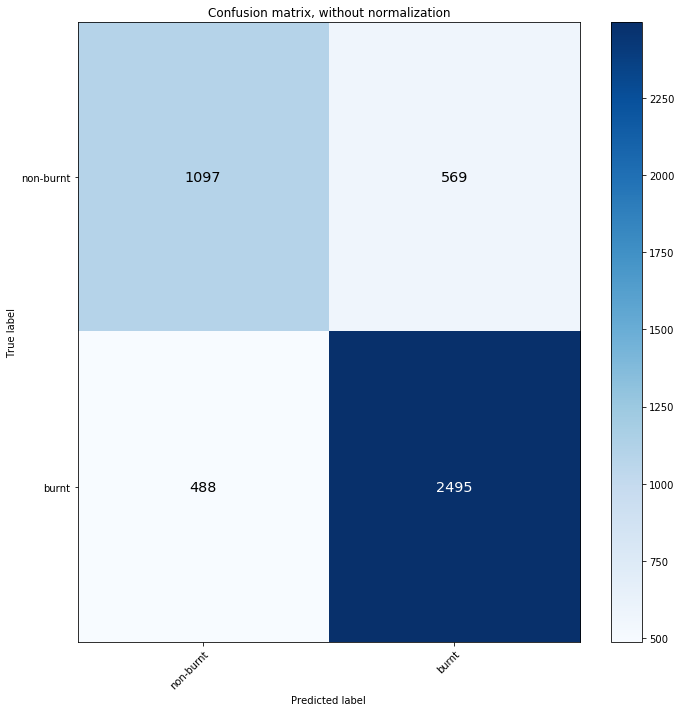

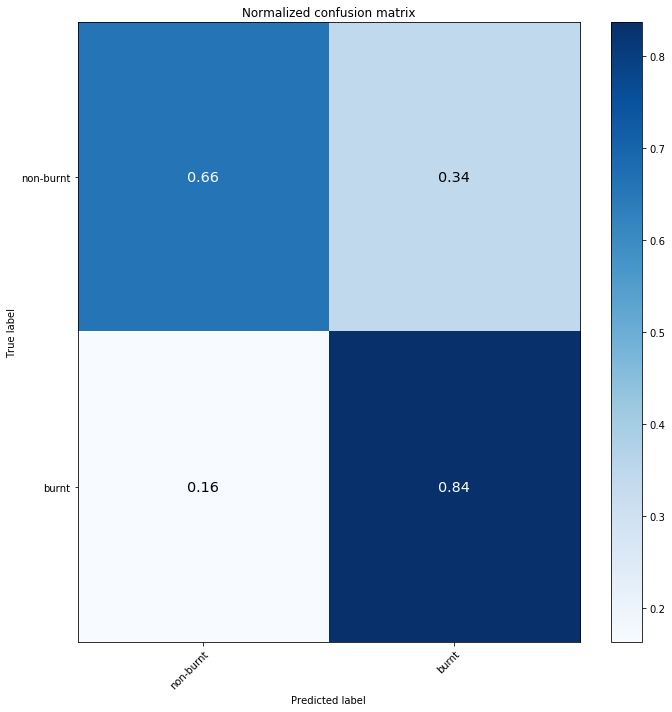

In [40]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

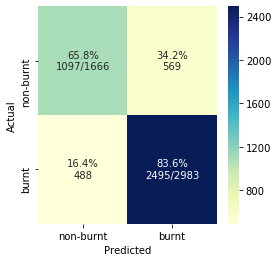

In [41]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_sgd_cm.png")

In [42]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1097, 569, 488, 2495)
	Accuracy = 77.26%
	Misclassification Rate = 22.74%
	Precision = 81.43%
	Recall = 83.64%
	F1-Score = 82.52%


#### Cross-validation

In [43]:
scores_sgd = cross_val_score(sgd, X_train, y_train, cv=10)
scores_sgd_p = cross_val_score(sgd, X_train, y_train, scoring='precision', cv=10)
scores_sgd_r = cross_val_score(sgd, X_train, y_train, scoring='recall', cv=10)
scores_sgd_f = cross_val_score(sgd, X_train, y_train, scoring='f1', cv=10)
scores_sgd

array([0.79365079, 0.77648305, 0.7595339 , 0.78283898, 0.76800847,
       0.78707627, 0.7804878 , 0.76776246, 0.75397667, 0.7359491 ])

In [44]:
models_df_sgd = pd.DataFrame({  
  'Model': ['SGD'],
  'Accuracy' : [strScoreConf(scores_sgd.mean(), scores_sgd.std())],
  'Precision': [strScoreConf(scores_sgd_p.mean(), scores_sgd_p.std())],
  'Recall' : [strScoreConf(scores_sgd_r.mean(), scores_sgd_r.std())],
  'F1' : [strScoreConf(scores_sgd_f.mean(), scores_sgd_f.std())]
})
models_df_sgd

,Model,Accuracy,Precision,Recall,F1
0,SGD,0.7706 (+/- 0.0322),0.8371 (+/- 0.1322),0.8240 (+/- 0.3171),0.6925 (+/- 0.4422)


## K-Nearest Neighbors

In [45]:
knn = KNeighborsClassifier() # n = 5
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
knn.score(X_test, y_test)

0.8354484835448484

Confusion matrix, without normalization
[[1193  473]
 [ 292 2691]]
Normalized confusion matrix
[[0.71608643 0.28391357]
 [0.09788803 0.90211197]]


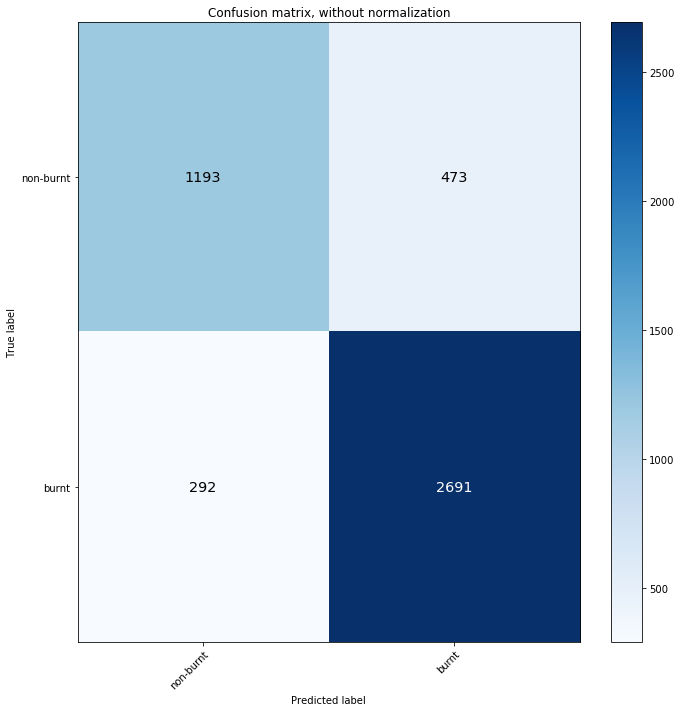

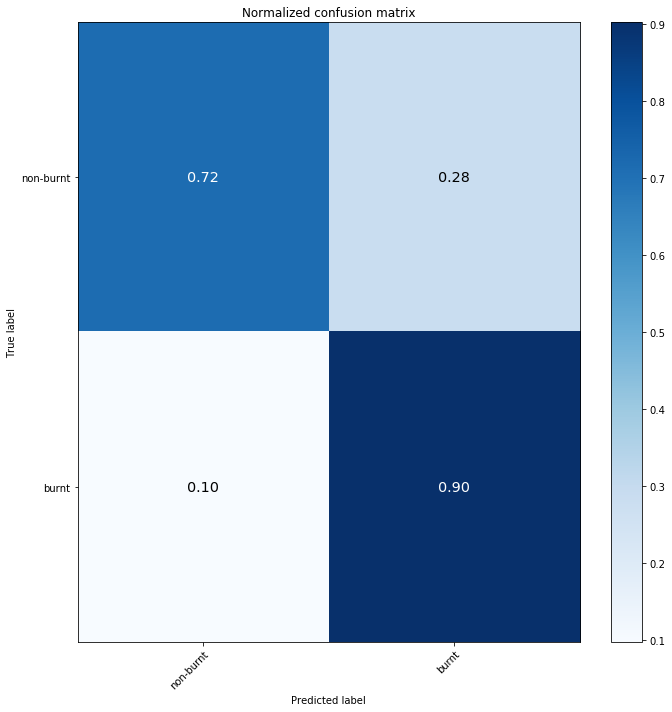

In [46]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

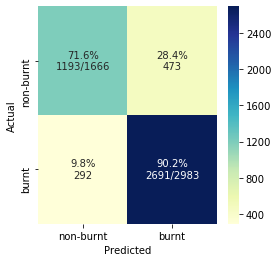

In [47]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_knn_cm.png")

In [48]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1193, 473, 292, 2691)
	Accuracy = 83.54%
	Misclassification Rate = 16.46%
	Precision = 85.05%
	Recall = 90.21%
	F1-Score = 87.55%


#### Cross-validation

In [49]:
scores_knn = cross_val_score(knn, X_train, y_train, cv=10)
scores_knn_p = cross_val_score(knn, X_train, y_train, scoring='precision', cv=10)
scores_knn_r = cross_val_score(knn, X_train, y_train, scoring='recall', cv=10)
scores_knn_f = cross_val_score(knn, X_train, y_train, scoring='f1', cv=10)
scores_knn

array([0.83492063, 0.82627119, 0.81567797, 0.83368644, 0.84322034,
       0.83580508, 0.83351007, 0.82820785, 0.84305408, 0.83563097])

In [50]:
models_df_knn = pd.DataFrame({  
  'Model': ['KNN'],
  'Accuracy' : [strScoreConf(scores_knn.mean(), scores_knn.std())],
  'Precision': [strScoreConf(scores_knn_p.mean(), scores_knn_p.std())],
  'Recall' : [strScoreConf(scores_knn_r.mean(), scores_knn_r.std())],
  'F1' : [strScoreConf(scores_knn_f.mean(), scores_knn_f.std())]
})
models_df_knn

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.8330 (+/- 0.0151),0.8515 (+/- 0.0149),0.8963 (+/- 0.0317),0.8732 (+/- 0.0131)


## Decision Tree

In [51]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_predict = dtc.predict(X_test)
dtc.score(X_test, y_test)

0.8038287803828781

Confusion matrix, without normalization
[[1229  437]
 [ 475 2508]]
Normalized confusion matrix
[[0.73769508 0.26230492]
 [0.15923567 0.84076433]]


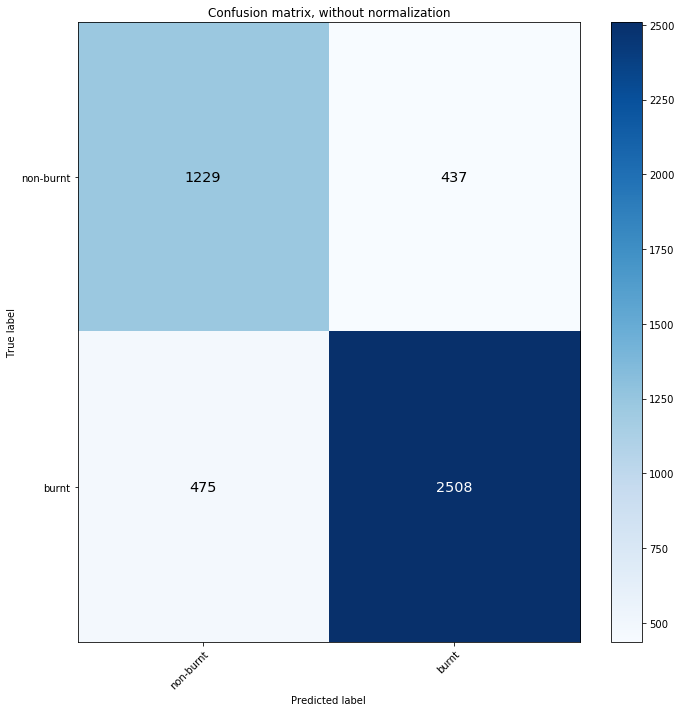

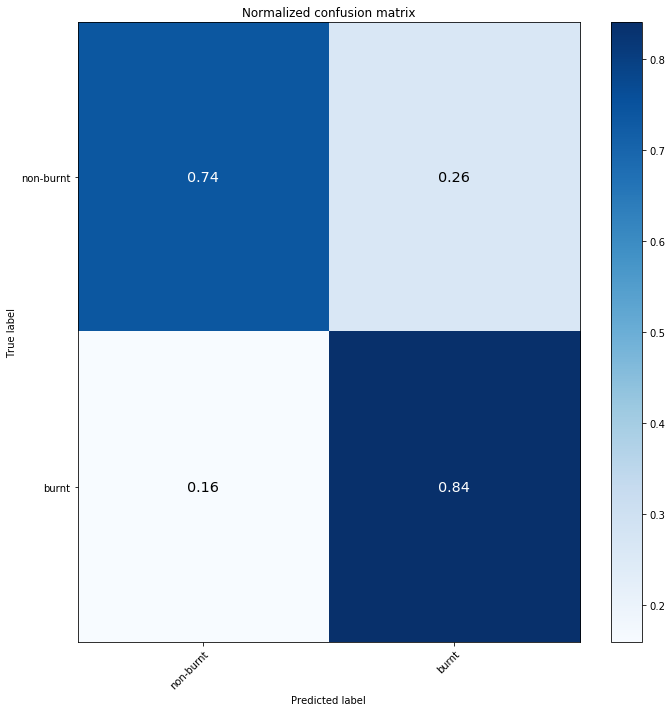

In [52]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

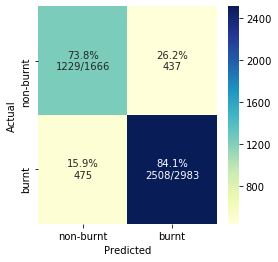

In [53]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_dtc_cm.png")

In [54]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1229, 437, 475, 2508)
	Accuracy = 80.38%
	Misclassification Rate = 19.62%
	Precision = 85.16%
	Recall = 84.08%
	F1-Score = 84.62%


#### Cross-validation

In [55]:
scores_dtc = cross_val_score(dtc, X_train, y_train, cv=10)
scores_dtc_p = cross_val_score(dtc, X_train, y_train, scoring='precision', cv=10)
scores_dtc_r = cross_val_score(dtc, X_train, y_train, scoring='recall', cv=10)
scores_dtc_f = cross_val_score(dtc, X_train, y_train, scoring='f1', cv=10)
scores_dtc

array([0.7968254 , 0.80826271, 0.78072034, 0.7934322 , 0.82521186,
       0.80402542, 0.80699894, 0.81124072, 0.79957582, 0.80699894])

In [56]:
models_df_dtc = pd.DataFrame({  
  'Model': ['DecnTree'],
  'Accuracy' : [strScoreConf(scores_dtc.mean(), scores_dtc.std())],
  'Precision': [strScoreConf(scores_dtc_p.mean(), scores_dtc_p.std())],
  'Recall' : [strScoreConf(scores_dtc_r.mean(), scores_dtc_r.std())],
  'F1' : [strScoreConf(scores_dtc_f.mean(), scores_dtc_f.std())]
})
models_df_dtc

,Model,Accuracy,Precision,Recall,F1
0,DecnTree,0.8033 (+/- 0.0220),0.8473 (+/- 0.0122),0.8463 (+/- 0.0243),0.8470 (+/- 0.0089)


## SVM

In [57]:
#Support Vector Classifier
#svc_lin = svm.SVC(kernel='linear')
svc_rbf = svm.SVC(kernel='rbf')
#svc_poly = svm.SVC(kernel='poly')

#svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
#svc_poly.fit(X_train, y_train)

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [58]:
#y_pred_l = svc_lin.predict(X_test)
y_pred_r = svc_rbf.predict(X_test)
#y_pred_p = svc_poly.predict(X_test)

#### Results SVC linear kernel

In [93]:
# print(confusion_matrix(y_test, y_pred_l))
# print_scores(y_test, y_pred_l)

[[1064  602]
 [ 198 2785]]
	(tn, fp, fn, tp) = (1064, 602, 198, 2785)
	Accuracy = 82.79%
	Misclassification Rate = 17.21%
	Precision = 82.23%
	Recall = 93.36%
	F1-Score = 87.44%


#### Results SVC RBF kernel

Confusion matrix, without normalization
[[ 439 1227]
 [  90 2893]]
Normalized confusion matrix
[[0.2635054  0.7364946 ]
 [0.03017097 0.96982903]]


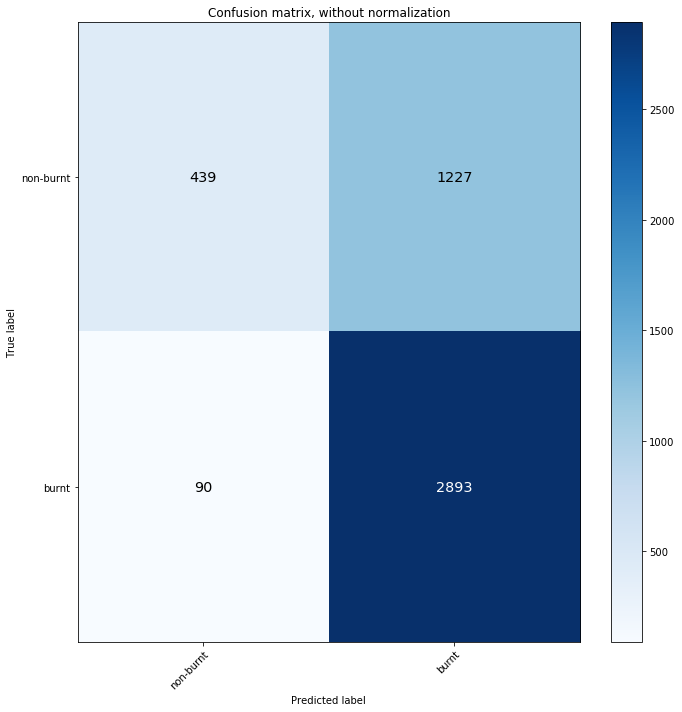

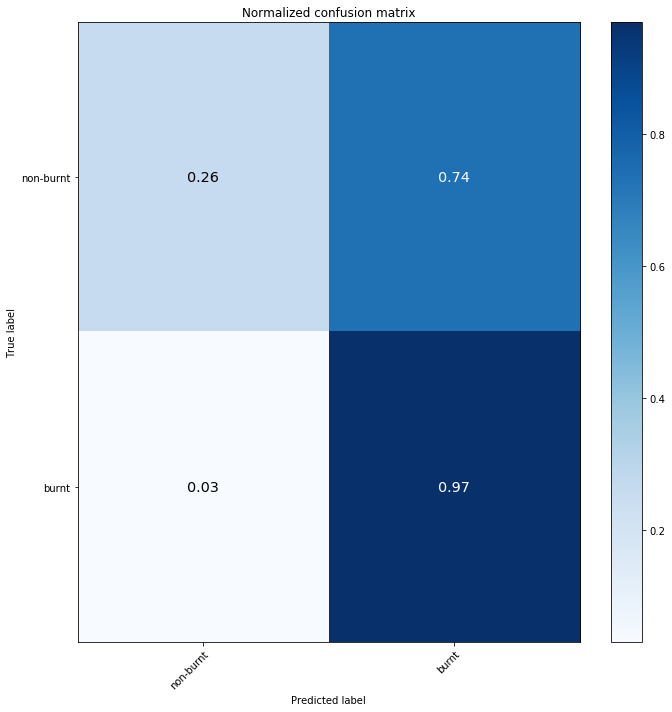

In [59]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_pred_r, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_pred_r, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

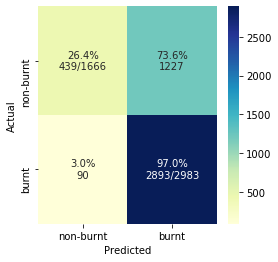

In [65]:
plot_cm(y_test, y_pred_r, figsize=(4,4), classes=class_names, figname="results/bin_svm_cm.png")


In [60]:
#print(confusion_matrix(y_test, y_pred_r))
print_scores(y_test, y_pred_r)

	(tn, fp, fn, tp) = (439, 1227, 90, 2893)
	Accuracy = 71.67%
	Misclassification Rate = 28.33%
	Precision = 70.22%
	Recall = 96.98%
	F1-Score = 81.46%


#### Results SVC polynomial kernel

In [95]:
# print(confusion_matrix(y_test, y_pred_p))
# print_scores(y_test, y_pred_p)

[[1216  450]
 [ 233 2750]]
	(tn, fp, fn, tp) = (1216, 450, 233, 2750)
	Accuracy = 85.31%
	Misclassification Rate = 14.69%
	Precision = 85.94%
	Recall = 92.19%
	F1-Score = 88.95%


#### Cross-validation

In [61]:
# #trying RBF since it is the default parameter
scores_svc = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, cv=10)

scores_svc

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: S

array([0.70687831, 0.72033898, 0.68432203, 0.72139831, 0.71292373,
       0.70762712, 0.72216331, 0.70307529, 0.7126193 , 0.71792153])

In [63]:
scores_svc_p = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='precision', cv=10)
scores_svc_r = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='recall', cv=10)
scores_svc_f = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='f1', cv=10)

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: S

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version

C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ailin\Anaconda3\envs\gdal_env\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [64]:
models_df_svc = pd.DataFrame({  
  'Model': ['SVM'],
  'Accuracy' : [strScoreConf(scores_svc.mean(), scores_svc.std())],
  'Precision': [strScoreConf(scores_svc_p.mean(), scores_svc_p.std())],
  'Recall' : [strScoreConf(scores_svc_r.mean(), scores_svc_r.std())],
  'F1' : [strScoreConf(scores_svc_f.mean(), scores_svc_f.std())]
})
models_df_svc

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.7109 (+/- 0.0213),0.6971 (+/- 0.0134),0.9721 (+/- 0.0194),0.8119 (+/- 0.0136)


## ANN - Multi-layer Perceptron Classifier (MLP)

In [66]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_predict = mlp.predict(X_test)
mlp.score(X_test, y_test)

0.8494299849429985

Confusion matrix, without normalization
[[1315  351]
 [ 349 2634]]
Normalized confusion matrix
[[0.78931573 0.21068427]
 [0.11699631 0.88300369]]


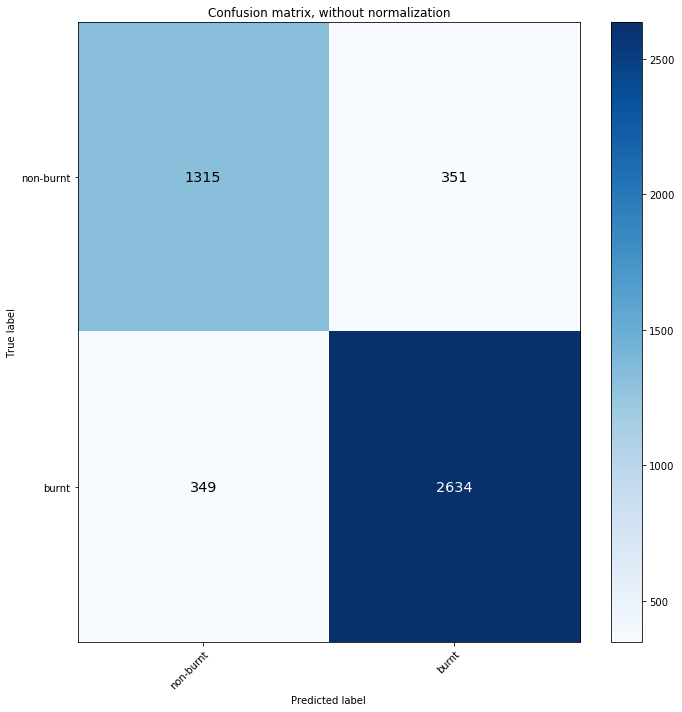

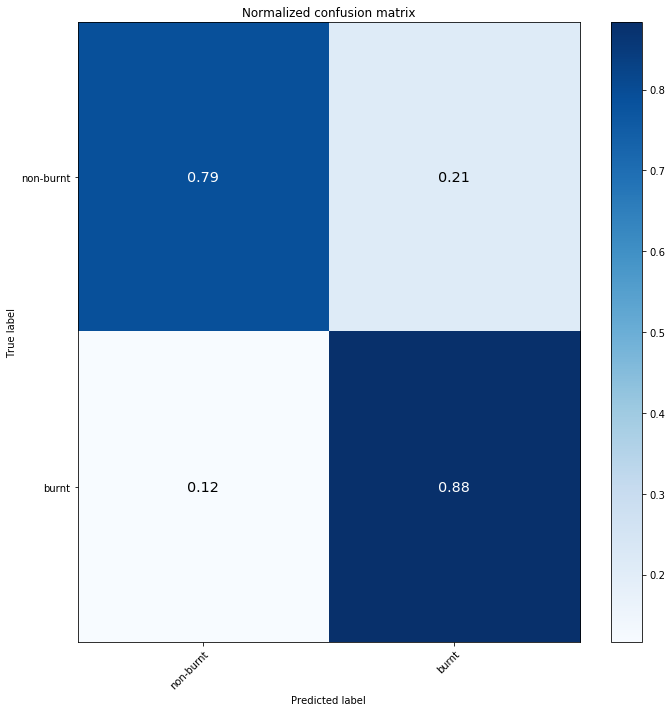

In [67]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

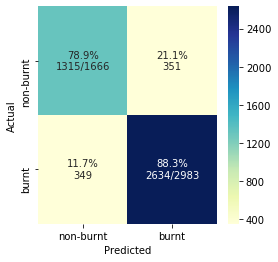

In [68]:
plot_cm(y_test, y_predict, figsize=(4,4), classes=class_names, figname="results/bin_mlp_cm.png")

In [69]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1315, 351, 349, 2634)
	Accuracy = 84.94%
	Misclassification Rate = 15.06%
	Precision = 88.24%
	Recall = 88.30%
	F1-Score = 88.27%


#### Cross-validation

In [70]:
scores_mlp = cross_val_score(mlp, X_train, y_train, cv=10)
scores_mlp_p = cross_val_score(mlp, X_train, y_train, scoring='precision', cv=10)
scores_mlp_r = cross_val_score(mlp, X_train, y_train, scoring='recall', cv=10)
scores_mlp_f = cross_val_score(mlp, X_train, y_train, scoring='f1', cv=10)
scores_mlp

array([0.83068783, 0.83368644, 0.8315678 , 0.85063559, 0.84322034,
       0.84216102, 0.8621421 , 0.83138918, 0.84623542, 0.85153765])

In [71]:
models_df_mlp = pd.DataFrame({  
  'Model': ['ANN-MLP'],
  'Accuracy' : [strScoreConf(scores_mlp.mean(), scores_mlp.std())],
  'Precision': [strScoreConf(scores_mlp_p.mean(), scores_mlp_p.std())],
  'Recall' : [strScoreConf(scores_mlp_r.mean(), scores_mlp_r.std())],
  'F1' : [strScoreConf(scores_mlp_f.mean(), scores_mlp_f.std())]
})
models_df_mlp

,Model,Accuracy,Precision,Recall,F1
0,ANN-MLP,0.8423 (+/- 0.0197),0.8702 (+/- 0.0533),0.9127 (+/- 0.1215),0.8760 (+/- 0.0427)


#### Save models via Pickle

In [103]:
import pickle
filepath = Path("./models")

In [104]:
#random forest
filenameRF = filepath / "randomForest_default_v2.sav"
pickle.dump(rf, open(filenameRF, 'wb'))

In [105]:
#logistic regression
filenameLR = filepath / "logisticRegression_default_v2.sav"
pickle.dump(lr, open(filenameLR, 'wb'))

In [106]:
#Gaussian Naive Bayes
filenameGNB = filepath / "gaussNB_default_v2.sav"
pickle.dump(gnb, open(filenameGNB, 'wb'))

#Bernoulli Naive Bayes
filenameBNB = filepath / "bernNB_default_v2.sav"
pickle.dump(bnb, open(filenameBNB, 'wb'))

In [107]:
#Stochastic Gradient Descent
filenameSGD = filepath / "stochGradDesc_default_v2.sav"
pickle.dump(sgd, open(filenameSGD, 'wb'))

In [108]:
#K-Nearest Neighbors - k=5
filenameKNN = filepath / "kNearestNeigh_default_v2.sav"
pickle.dump(knn, open(filenameKNN, 'wb'))

In [109]:
#Decision Tree Classifier
filenameDTC = filepath / "decisionTree_default_v2.sav"
pickle.dump(dtc, open(filenameDTC, 'wb'))

In [110]:
#Support Vector Machine - Linear Kernel
filenameSVCLin = filepath / "svm_lin_default_v2.sav"
pickle.dump(svc_lin, open(filenameSVCLin, 'wb'))

#Support Vector Machine - Radial Basis Function (RBF) Kernel
filenameSVCRbf = filepath / "svm_rbf_default_v2.sav"
pickle.dump(svc_rbf, open(filenameSVCRbf, 'wb'))

#Support Vector Machine - Polynomial Kernel
filenameSVCPoly = filepath / "svm_poly_default_v2.sav"
pickle.dump(svc_poly, open(filenameSVCPoly, 'wb'))

In [111]:
#Multi-Layer Perceptron Network (MLP)
filenameMLP = filepath / "mlp_default_v2.sav"
pickle.dump(mlp, open(filenameMLP, 'wb'))

In [112]:
#save X and y numpy arrays
filepathData = Path("./data")
np.save(filepathData / "X_v2.npy", X)
np.save(filepathData / "y_v2.npy", y)

## Cross-validation metrics

In [72]:
models_df = pd.concat([models_df_rf, models_df_lr, models_df_gnb, models_df_bnb,
                       models_df_sgd, models_df_knn, models_df_dtc, models_df_svc, models_df_mlp])
models_df.sort_values(by='Precision', ascending=False)

,Model,Accuracy,Precision,Recall,F1
0,RandForest,0.8571 (+/- 0.0176),0.8862 (+/- 0.0197),0.8937 (+/- 0.0212),0.8921 (+/- 0.0113)
0,ANN-MLP,0.8423 (+/- 0.0197),0.8702 (+/- 0.0533),0.9127 (+/- 0.1215),0.8760 (+/- 0.0427)
0,KNN,0.8330 (+/- 0.0151),0.8515 (+/- 0.0149),0.8963 (+/- 0.0317),0.8732 (+/- 0.0131)
0,DecnTree,0.8033 (+/- 0.0220),0.8473 (+/- 0.0122),0.8463 (+/- 0.0243),0.8470 (+/- 0.0089)
0,SGD,0.7706 (+/- 0.0322),0.8371 (+/- 0.1322),0.8240 (+/- 0.3171),0.6925 (+/- 0.4422)
0,GaussNB,0.8129 (+/- 0.0195),0.8364 (+/- 0.0225),0.8809 (+/- 0.0204),0.8580 (+/- 0.0141)
0,LogReg,0.8313 (+/- 0.0228),0.8360 (+/- 0.0239),0.9173 (+/- 0.0241),0.8747 (+/- 0.0164)
0,BernNB,0.7607 (+/- 0.0192),0.7528 (+/- 0.0184),0.9341 (+/- 0.0141),0.8337 (+/- 0.0115)
0,SVM,0.7109 (+/- 0.0213),0.6971 (+/- 0.0134),0.9721 (+/- 0.0194),0.8119 (+/- 0.0136)
